<a href="https://colab.research.google.com/github/Sentinel-FYP/colab_notebooks/blob/main/sentinel_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Dependencies and Set Constants

### Install Dependencies

In [ ]:
!pip install tqdm opencv-python opencv-python-headless tf-models-official
!pip install -q git+https://github.com/tensorflow/docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.2 MB/s eta 0:00:00


### Import Packages

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import zipfile as zf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model

### Set Hyperparams

In [ ]:
num_classes = 2
batch_size = 1
resolution = 172
num_frames = 64
frame_step = 1
dropout_rate=0.
bias_regularizer=0.
epochs = 5
model_id = 'a0'
export_model = False
start_from_checkpoint = False
evaluate = False
export_model_name = 'a0_stream_5.0'
frame_shape = (num_frames, resolution, resolution, 3)
input_shape = (batch_size, num_frames, resolution, resolution, 3)

### Create Directory Structure

In [ ]:
paths = {}
paths['root'] = pathlib.Path('/content/drive/MyDrive/ucf_dataset')
assert paths['root'].exists() == True
paths['models'] = (paths['root'] / 'models' / model_id)
paths['tflite'] = (paths['root'] / 'tf_lite_models' / model_id)
paths['checkpoints_dir'] = (paths['root'] / 'checkpoints' / model_id / export_model_name)

In [ ]:
for p in paths.values():
  assert p.exists()

## Load Data

### Load Annotations

In [ ]:
annotations = pd.read_csv(paths['root'] / 'frame_annotations.csv')
annotations = annotations.set_index('file_name')
annotations['binary_class'] = annotations['is_annomaly'].map({1.0 : 'Anomaly', 0.0 : "Normal"})

### Define Helper Functions

In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename/file_path.

    Args:
      fname: Name of the file in the UCF Crime dataset.
    Returns:
      Class that the file belongs to.
  """
  fname = fname.split('/')[-1]
  class_name = fname.split('_')[0]
  #remove numbers
  class_name = ''.join(char for char in class_name if not char.isnumeric())
  if class_name == "Normal":
    return "Normal"
  else:
    return "Anomaly"

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def get_video_annotations(video_path, annotations_df=annotations):
  video_name = str(video_path).split("/")[-1]
  return annotations_df.loc[video_name].to_dict()

In [ ]:
# def frames_from_video_file(video_path, n_frames, output_size, frame_step):
#   """
#     Creates frames from each video file present for each category.

#     Args:
#       video_path: File path to the video.
#       n_frames: Number of frames to be created per video file.
#       output_size: Pixel size of the output frame image.

#     Return:
#       An NumPy array of frames in the shape of (n_frames, height, width, channels).
#   """
#   # Read each video frame by frame
#   video_annotations = get_video_annotations(video_path)
#   result = []
#   src = cv2.VideoCapture(str(video_path))

#   video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
#   need_length = 1 + (n_frames - 1) * frame_step
#   if video_annotations['anomaly_1_start'] == -1:
#     if need_length > video_length:
#       start = 0
#       end = video_length
#     else:
#       max_start = video_length - need_length
#       start = random.randint(0, max_start + 1)
#       end = start + need_length
#   else:
#     start = video_annotations['anomaly_1_start']
#     end = video_annotations['anomaly_1_end']
#   src.set(cv2.CAP_PROP_POS_FRAMES, start)
#   # ret is a boolean indicating whether read was successful, frame is the image itself
#   ret, frame = src.read()
#   frame_count = start + 1;
#   result.append(format_frames(frame, output_size))

#   for _ in range(n_frames - 1):
#     for _ in range(frame_step):
#       ret, frame = src.read()
#       frame_count += 1;
#     if ret and frame_count < end and frame is not None:
#       frame = format_frames(frame, output_size)
#       result.append(frame)
#     else:
#       break
#   src.release()
#   result = np.array(result)[..., [2, 1, 0]]

#   return result

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size, frame_step):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  video_annotations = get_video_annotations(video_path)
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = n_frames
  if video_annotations['anomaly_1_start'] == -1:
    if need_length > video_length:
      start = 0
      end = video_length
    else:
      max_start = video_length - need_length
      start = random.randint(0, max_start)
      end = start + need_length
  else:
    start = video_annotations['anomaly_1_start']
    end = video_annotations['anomaly_1_end']
    if need_length < (end - start):
      max_start = end - need_length
      start = random.randint(start, max_start)
      end = start + need_length

  src.set(cv2.CAP_PROP_POS_FRAMES, start)

  for _ in range(n_frames):
    ret, frame = src.read()
    if ret and frame is not None:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      break
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

### Create Dataset Paths

In [ ]:
dataset_paths = {}
dataset_directory = pathlib.Path('/content/drive/MyDrive/ucf_extracted')
dataset_paths['train'] = dataset_directory / 'train'
dataset_paths['test'] = dataset_directory / 'test'

In [ ]:
for p in dataset_paths.values():
  assert p.exists() == True

In [ ]:
video_count_train = len(list(dataset_directory.glob('train/*/*.mp4')))
video_count_test = len(list(dataset_directory.glob('test/*/*.mp4')))
video_total = video_count_train + video_count_test
print(f'Total training videos: {video_count_train}')
print(f'Total training test: {video_count_test}')
print(f"Total videos: {video_total}")

Total training videos: 849
Total training test: 150
Total videos: 999


### Create Dataset Generator


In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames=num_frames, output_size=(resolution, resolution), frame_step=frame_step, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.output_size = output_size
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()
    pairs = list(zip(video_paths, classes))
    if self.training:
      random.shuffle(pairs)
    for path, name in pairs:
      try:
        video_frames = frames_from_video_file(path, self.n_frames, output_size=self.output_size, frame_step=frame_step)
      except Exception as exc:
        print(f'Error on {path}')
        print(exc)
        continue
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label


In [ ]:
output_signature = (tf.TensorSpec(shape =(None, resolution, resolution, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(dataset_paths['train'], training = True),
                                          output_signature=output_signature
                                          )
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(dataset_paths['test']),
                                        output_signature=output_signature
                                         )
test_ds = test_ds.batch(batch_size)

In [ ]:
for frames, labels in train_ds.take(1):
  print(f"Frames Shape: {frames.shape}, Dtype: {frames.dtype}")
  print(f"Label Shape: {labels.shape}, Dtype: {labels.dtype}")

Frames Shape: (1, 64, 172, 172, 3), Dtype: <dtype: 'float32'>
Label Shape: (1,), Dtype: <dtype: 'int16'>


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Model Loading

### Construct the backbone with proper parameters

In [ ]:
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False,
)

### Construct the model

In [ ]:
if not start_from_checkpoint:
  model = movinet_model.MovinetClassifier(
      backbone,
      num_classes=600,
      output_states=True)

  model.build(input_shape)

### Load the pretrained weights

In [ ]:
if not start_from_checkpoint:
  # Extract pretrained weights
  !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_stream.tar.gz -O movinet_a0_stream.tar.gz -q
  !tar -xvf movinet_a0_stream.tar.gz

  checkpoint_dir = 'movinet_a0_stream'
  checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
  checkpoint = tf.train.Checkpoint(model=model)
  status = checkpoint.restore(checkpoint_path)
  status.assert_existing_objects_matched()

movinet_a0_stream/
movinet_a0_stream/ckpt-1.data-00000-of-00001
movinet_a0_stream/ckpt-1.index
movinet_a0_stream/checkpoint


### Set up the distribution strategy

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


### Construct custom classifier with required number of classes

In [ ]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes, dropout_rate, bias_regularizer):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes,
      dropout_rate=dropout_rate,
      bias_regularizer=tf.keras.regularizers.L2(bias_regularizer))
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

# Construct loss, optimizer and compile the model
with distribution_strategy.scope():
  model = build_classifier(batch_size, None, resolution, backbone, num_classes, dropout_rate, bias_regularizer)
  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

### Start From Previous Checkpoint

In [ ]:
if start_from_checkpoint:
  model.load_weights(tf.train.latest_checkpoint(paths['checkpoints_dir']))
  print('Loading from: ',tf.train.latest_checkpoint(paths['checkpoints_dir']))

## Model Training

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=paths['checkpoints_dir'] / 'cp.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs,
                    validation_freq=1,
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/5
    849/Unknown - 1177s 1s/step - loss: 0.7085 - accuracy: 0.5901
Epoch 1: saving model to /content/drive/MyDrive/ucf_dataset/checkpoints/a0/a0_stream_5.0/cp.ckpt
849/849 [==============================] - 1376s 1s/step - loss: 0.7085 - accuracy: 0.5901 - val_loss: 0.7129 - val_accuracy: 0.4867
Epoch 2/5
  7/849 [..............................] - ETA: 18:13 - loss: 0.6299 - accuracy: 0.7143Error on /content/drive/MyDrive/ucf_extracted/train/Anomaly/Burglary005_x264.mp4
index 2 is out of bounds for axis 0 with size 0
Error on /content/drive/MyDrive/ucf_extracted/train/Anomaly/Arrest041_x264.mp4
index 2 is out of bounds for axis 0 with size 0
Error on /content/drive/MyDrive/ucf_extracted/train/Anomaly/RoadAccidents009_x264.mp4
index 2 is out of bounds for axis 0 with size 0
Error on /content/drive/MyDrive/ucf_extracted/train/Anomaly/Arson049_x264.mp4
index 2 is out of bounds for axis 0 with size 0
Error on /content/drive/MyDrive/ucf_extracted/train/Normal/Normal_Videos479_x264.


Epoch 2: saving model to /content/drive/MyDrive/ucf_dataset/checkpoints/a0/a0_stream_5.0/cp.ckpt
849/849 [==============================] - 135s 158ms/step - loss: 0.6299 - accuracy: 0.7143 - val_loss: 0.8851 - val_accuracy: 0.4733


## Evaluation

### Plot History

<Figure size 640x480 with 0 Axes>

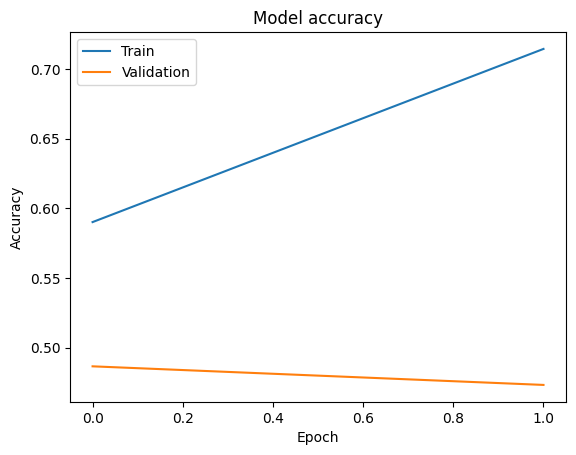

In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

%matplotlib inline
plt.figure()
plot_training_history(results)

## Exporting Model

### Reconstruct the whole model with use_external_states=True to make the inference using states.

In [ ]:
if export_model:
  model_id = 'a0'
  use_positional_encoding = model_id in {'a3', 'a4', 'a5'}

  # Create backbone and model.
  backbone = movinet.Movinet(
      model_id=model_id,
      causal=True,
      conv_type='2plus1d',
      se_type='2plus3d',
      activation='hard_swish',
      gating_activation='hard_sigmoid',
      use_positional_encoding=use_positional_encoding,
      use_external_states=True,
  )

  model = movinet_model.MovinetClassifier(
      backbone,
      num_classes=num_classes,
      output_states=True)


  # [Optional] Build the model and load a pretrained checkpoint.
  model.build(input_shape)

  # Load weights from the checkpoint to the rebuilt model
  model.load_weights(tf.train.latest_checkpoint(paths['checkpoints_dir']))

### Export to saved model

In [ ]:
if export_model:
  saved_model_dir = paths['models'] / export_model_name
  tflite_filename = paths['tflite']  / (export_model_name + ".tflite")
  # Convert to saved model
  export_saved_model.export_saved_model(
      model=model,
      input_shape=[1, 1, resolution, resolution, 3],
      export_path=saved_model_dir,
      causal=True,
      bundle_input_init_states_fn=False)

### Convert to TF Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(str(saved_model_dir))
tflite_model = converter.convert()

with open(tflite_filename, 'wb') as f:
  f.write(tflite_model)

NameError: ignored